# MOT data analysis
This notebook will use an sqlite database file already generated by another notebook.  It will perform some SQL querying to filter and sort the data.  Then make use of pandas, numpy, matplotlib, seaborn etc to do some exploratory data analysis.  My intention is to then train some machine learning models to try to provide useful insight from the data such as trends, predicted test pass rates etc.

## Setup database access

In [1]:
# Import and create a new database file
import sqlite3
from sqlite3 import Error
import os

def create_connection(path):
    connection = None
    try:
        connection = sqlite3.connect(path)
        print("Connection to SQLite DB successful")
    except Error as e:
        print(f"The error '{e}' occurred")

    return connection

connection = create_connection(os.path.join('data','mot.sqlite'))

Connection to SQLite DB successful


In [2]:
# Create function to simply execute query
def execute_query(connection, query, firstonly=False, verbose=True):
    cursor = connection.cursor()
    try:
        cursor.execute(query)
        connection.commit()
        if verbose:print("Query executed successfully");
    except Error as e:
        print(f"The error '{e}' occurred")
    if firstonly:
        return cursor.fetchone()
    else:
        return cursor.fetchall()

def insert_query(connection, query, t, verbose=True):
    cursor = connection.cursor()
    try:
        cursor.executemany(query, t)
        connection.commit()
        if verbose:print("Query executed successfully");
    except Error as e:
        print(f"The error '{e}' occurred")
    return

In [3]:
import pandas as pd
import os

# Run some initial queries

In [4]:
# Get number of rows in database
response = execute_query(connection,'''SELECT COUNT(test_id) FROM mot1;''')

print(f'Number of entries in test_id are: {response[0][0]}')

Query executed successfully
Number of entries in test_id are: 39310698


In [6]:
# Print first 5 entries
pd.read_sql_query('''SELECT * FROM mot1 LIMIT 5''', connection)

,test_id,vehicle_id,test_date,test_class_id,test_type,test_result,test_mileage,postcode_area,make,model,colour,fuel_type,cylinder_capacity,first_use_date
0,949308439,831850247,2019-04-01 00:00:00,4,NT,0,11495,LU,FORD,FIESTA,WHITE,PE,998,2016-06-06 00:00:00
1,864011467,1337370923,2019-04-01 00:00:00,7,NT,0,144959,S,MERCEDES-BENZ,SPRINTER,SILVER,DI,2143,2015-06-01 00:00:00
2,906659953,134104785,2019-04-01 00:00:00,4,NT,1,13234,LU,RENAULT,CAPTUR,CREAM,DI,1461,2014-05-09 00:00:00
3,821362981,697598213,2019-04-01 00:00:00,4,NT,0,47127,S,KIA,RIO,BLUE,DI,1396,2013-03-04 00:00:00
4,778714495,1033590608,2019-04-01 00:00:00,4,NT,0,46895,LU,VAUXHALL,CORSA,GREY,PE,1229,2012-03-12 00:00:00


In [20]:
# How many distinct vehicle makes are there
count_makes = execute_query(connection,'''SELECT COUNT( DISTINCT make ) FROM mot1;''')

print(f'Number of distinct vehicle makes: {count_makes[0][0]}')

Query executed successfully
Number of distinct vehicle makes: 10542


In [37]:
# Print counts according to test_class_id
df = pd.read_sql_query('''SELECT test_class_id, COUNT(*) AS count
FROM mot1
GROUP BY test_class_id
ORDER BY count DESC;''', connection)
df

,test_class_id,count
0,4,37203595
1,7,1011969
2,2,770414
3,1,255584
4,5,57371
5,3,11765


# Do some data filtering and generate a new view in the sqlite db

In [60]:
# Create db view with class=4, dates 2019 only
execute_query(connection,'''
DROP VIEW mot2;''')

execute_query(connection,'''
CREATE TEMP VIEW mot2 AS
SELECT test_id, vehicle_id, test_date, test_type, 
    test_result, test_mileage, postcode_area, make,
    model, colour, fuel_type, cylinder_capacity, first_use_date
FROM mot1
WHERE test_date BETWEEN "01/01/2019" AND "31/12/2019"
AND test_class_id = 4
;''');

Query executed successfully


In [66]:
print('Count of records in view "mot2" = ',execute_query(connection,'''
SELECT COUNT(test_id)
FROM mot2;''')[0][0])

Query executed successfully
Count of records in view "mot2" =  37203595


In [67]:
# Create db view with class=4, dates 2019 ... and test type='NT'
execute_query(connection,'''
DROP VIEW mot2;''')

execute_query(connection,'''
CREATE TEMP VIEW mot3 AS
SELECT test_id, vehicle_id, test_date, test_type, 
    test_result, test_mileage, postcode_area, make,
    model, colour, fuel_type, cylinder_capacity, first_use_date
FROM mot1
WHERE test_date BETWEEN "01/01/2019" AND "31/12/2019"
AND test_class_id = 4
AND test_type = 'NT'
;''');

Query executed successfully
Query executed successfully


In [68]:
print('Count of records in view "mot3" = ',execute_query(connection,'''
SELECT COUNT(test_id)
FROM mot3;''')[0][0])

Query executed successfully
Count of records in view "mot3" =  30285175


## Try to generate a df from mot3 table view

In [ ]:
import sys
tempdf = pd.read_sql_query('''SELECT *
FROM mot3
LIMIT 10000000;''', connection)

print(sys.getsizeof(tempdf),'bytes')

## Print some EDA stats on the filtered db view

In [21]:
# Print 10 most common makes
top10makes = pd.read_sql_query('''SELECT make, COUNT(*) AS count
FROM mot1
GROUP BY make
ORDER BY count DESC
LIMIT 10;''', connection)
top10makes

,make,count
0,FORD,5808680
1,VAUXHALL,4332494
2,VOLKSWAGEN,3468807
3,PEUGEOT,1954359
4,BMW,1904149
5,TOYOTA,1765993
6,NISSAN,1759774
7,AUDI,1636494
8,RENAULT,1549686
9,CITROEN,1435757


Check distribution among vehicle classes.  Most records are for class 4 vehicles (covers all cars and vehicles up to 3Ton, 8 passengers) as expected

In [13]:
# Print 10 most common makes
df = pd.read_sql_query('''SELECT COUNT(test_id)
FROM mot1
WHERE test_class_id = 4
LIMIT 10;''', connection)
df

,COUNT(test_id)
0,37203595


In [35]:
# Print 10 most common makes in class 4 vehicles only
top10makes_c4 = pd.read_sql_query('''SELECT make, COUNT(*) AS count
FROM mot1
WHERE test_class_id = 4
GROUP BY make
ORDER BY count DESC
LIMIT 10;''', connection)
top10makes_c4

,make,count
0,FORD,5400165
1,VAUXHALL,4258294
2,VOLKSWAGEN,3393707
3,PEUGEOT,1905439
4,BMW,1839410
5,TOYOTA,1761614
6,NISSAN,1733636
7,AUDI,1636450
8,RENAULT,1474208
9,CITROEN,1387180


<AxesSubplot:xlabel='make', ylabel='count'>

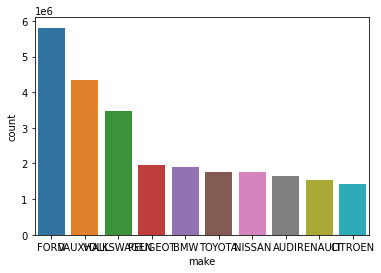

In [28]:
import seaborn as sns

sns.barplot(x=top10makes['make'],y=top10makes['count']);

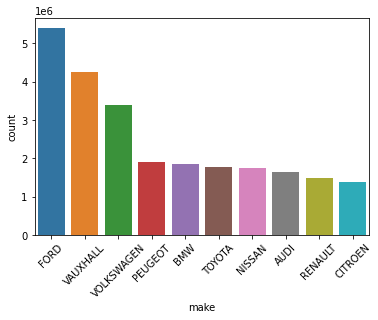

In [36]:
makesplot = sns.barplot(x=top10makes['make'],y=top10makes_c4['count']);
makesplot.set_xticklabels(makesplot.get_xticklabels(), rotation=45);